# RGI-07: Region 19 (Antarctic and Subantarctic)
##### F. Maussion & S. Galos, August 2021

Same as RGI6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir

## Files and storage paths

In [3]:
# Region of interest
reg = 19

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '19_rgi60_AntarcticSubantarctic.zip')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

## Apply selection criteria to create the RGI7 data subset

### Step 1: extract RGI6 from GLIMS data and do a check

In [5]:
#...extract RGI06 from GLIMS based on 'geog_area'
RGI_ss = shp.loc[shp['geog_area']=='Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS']

#### load reference data (here RGI6 original) to enable comparison

In [6]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements (differences do not necessarily depict major problems)

In [7]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 2752
Number of glaciers in reference data: 2752
Difference: 0


#### check for dublicate glacier IDs

In [8]:
print ('number of glaciers without unique id in RGI06:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))

number of glaciers without unique id in RGI06: 0


In [9]:
print ('number of glaciers without unique id in RGI06 from GLIMS data base:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

number of glaciers without unique id in RGI06 from GLIMS data base: 0


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [10]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

0

In [11]:
# drop nominal glaciers from new RGI subset
RGI_ss = (RGI_ss.loc[~RGI_ss['glac_id'].isin(nom['GLIMSId'])])

#### Total area

In [12]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

In [13]:
# print and compare area values
Area_Rep = RGI_ss['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 132870.1004613989
Area RGI6 [km²]: 132867.1533679446
Area Nom [km²]: 0.0
Area difference [km²]: 2.947093454306014 / percentage: 0.002218026060093329


### result of check (RGI from Glims global data base vs. RGI06 original):
#### same number of glaciers
#### 0 dublicate IDs
#### 0 nominal glaciers
#### nevertheless 3 km² area difference... which mainly originate from "small" outline differences between RGI06 original and the outlines of RGI06 extracted from the Glims data base. Main sources may be glaciers G302202E64176S and G290313E70685S (and possibly others).

## remaining tasks for RGI-7a:
#### - do detailed check of  issues mentioned above
#### - create data set of glaciers with edits in RGI-6 to be ingested in GLIMS
#### - since it was decided that data by Huber et al. wont be ingested, only add Moelg and Paul data as soon as in GLIMS

## Write out and tar 

In [14]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI19.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI19'], returncode=0)


## Find missing glaciers 

In [15]:
from utils import haversine
import numpy as np
import progressbar

In [16]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [17]:
df_ref = ref_odf.copy()
rgi7 = RGI_ss.copy()

In [18]:
# Remove nominal
df_ref = df_ref.loc[df_ref.Status != 2].copy()

In [19]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [20]:
df_ref_orig = df_ref.copy()

In [21]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (2752 of 2752) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [22]:
print(len(not_found), len(df_ref))

6 6


In [23]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

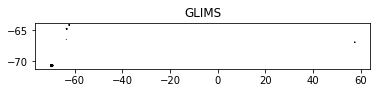

In [24]:
pb_rgi7.plot(edgecolor='k');
plt.title('GLIMS');

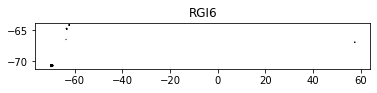

In [25]:
df_ref.plot(edgecolor='k');
plt.title('RGI6');

In [26]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [27]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI19.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI19'], returncode=0)
